In [93]:
import scipy, time, random, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from common.data_parser import *
from common.misc import *

In [94]:
def preprocess(df):
    
    #df = drop_cols(df, 0.1)
    df = df.replace(np.NaN, 0)
    df = df.astype('float')    

    print("Number of missing values:", count_missing_vals(df))
    return df


def drop_cols(df, cutoff):
    row_cnt = df.shape[0]
    dropped_cols = []

    # Iterate over columns and calculate relative amount of missing data
    for col in df:
        missing_cnt = df[col].isna().sum()

        # drop col if above cutoff
        if missing_cnt / row_cnt > cutoff:

            dropped_cols.append(col)

    df = df.drop(dropped_cols, axis=1)
    print("Dropped", dropped_cols)
    return df


def replace_missing_vals(df):
    for col in df:
        for entry in df[col]:
            if entry != True:
                df[col][entry] = 0
    return df

def count_missing_vals(df):   
    # Helopful ressource: https://towardsdatascience.com/how-to-check-for-missing-values-in-pandas-d2749e45a345
    return df.isna().sum().sum()

In [95]:
#df = parse_companies(5)
#df = pd.concat(df)
#df = preprocess(df)

#bancrupt_df = df.loc[df['class'] == 1]
#solvent_df = df.loc[df['class'] == 0].sample(bancrupt_df.shape[0])
#df = pd.concat([solvent_df, bancrupt_df])

In [96]:
df = parse_companies(5)
df = df.astype('float') 

data = df.iloc[:,2:-1]
labels = df.iloc[:,[-1]]

#df = df.replace(np.NaN, 0)

# Imputation
imp = SimpleImputer(missing_values=np.NaN, strategy="median") 
imp.fit(data)
data = imp.transform(data)


# Scaling
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(data_scaled)





x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1 )

In [97]:
def analyze_model(model, x_test):
    prediction = pd.DataFrame()
    prediction["class"] = model.predict(x_test)
    

    accuracy = compare_df(prediction, y_test, "class")[0]
    confusion_mat = confusion_matrix(y_test, prediction)
    cost = calculate_cost(confusion_mat)

    return [accuracy, cost]


def calculate_cost(conf_mat):
    """ Confusion Matrix:
    
                    actual solv.   actual bankrupt
    pred. solvent       10             -200
    pred. bancrup       -10               0
    
    """
    cost_mat = [
        [10, -500],
        [-50, 0]
    ]

    cost = conf_mat[0][0]*cost_mat[0][0] + conf_mat[1][1]*cost_mat[1][1] +\
        conf_mat[0][1]*cost_mat[0][1] + conf_mat[1][0]*cost_mat[1][0]

    return cost

Best score:  10620.0


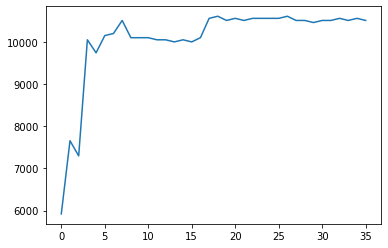

In [98]:
max_k = 40
min_k = 5
results = []
for k in range(min_k, max_k+1):
    model = KNeighborsClassifier(n_neighbors=k, weights="uniform").fit(x_train, y_train)
    results.append(analyze_model(model, x_test))
    
results = pd.DataFrame(results, columns=["accuracy", "cost"])
plt.plot(results["cost"])
best_index = results["cost"].argmax()
print("Best score: ", results.iloc[best_index]["cost"])